# УСЛОВНАЯ ОПТИМИЗАЦИЯ!

Раньше мы с вами решали задачи такого плана
$$
\min f(x)
$$
Где $x \in \mathbb{R}^n$

А теперь поговорим о таком
$$
 \min_{x \in P} f(x)
 $$
 
 Где $P $ - так называемое простое множество
 

## Что такое  "простое множество"?

![](simple_sets_polyak.png)

Переводя на русский, это множества на которых будет легко решить вспомогательную задачу (Какую, поговорим позже)

## Какие бывают простые множества?


- многогранники

- гиперплоскости

- полупространства

- отрезки

- симплексы


# Метод проекции градиента

$$
\min_{x \in P} f(x)
$$
**Идея**: делать шаг градиентного спуска и проецировать полученную точку на допустимое множество $P$.

## Псевдокод

```python
def ProjectedGradientDescent(f, gradf, proj, x0, tol):
    
    x = x0
    
    while True:
        
        gradient = gradf(x)
        
        alpha = get_step_size(x, f, gradf, proj) 
        
        x = proj(x - alpha * grad)
        
        if check_convergence(x, f, tol):
            
            break
            
    return x

```

## А что такое проекция??

Решение следующей задачи

Для данной точки $y \in \mathbb{R}^n$ 

$$
\min_{x \in P} \|x - y \|_2
$$

Обозначение: $\pi_P(y)$ - проекция точки $y$ на множество $P$.

Те на каждом шаге мы решаем задачу условной оптимизации!!


## Примеры проекций

- Отрезок $P = \{x | l \leq x \leq u \}$

$$
(\pi_P(y))_k = 
\begin{cases}
u_k & y_k \geq u_k \\
l_k & y_k \leq l_k \\
y_k & \text{otherwise.}
\end{cases}
$$

- Аффинное множество $P = \{ x| Ax = b \}$
$$
\pi_P(y) = y - A^+(Ay - b),
$$ 
где $A^+$ - псевдообратная матрица. Если $A$ полного ранга и столбцы линейно-независимы, тогда $A^+ = (A^{\top}A)^{-1}A^{\top}$.

## Поиск шага

- Постоянный шаг: $\alpha_k = \alpha$, где $\alpha$ достаточно мало
- Наискорейший спуск: 
$$
\min_{\alpha > 0} f(x_k(\alpha))
$$
$x_k(\alpha) = \pi_P (x_k - \alpha f'(x_k))$
<!-- - Линейный поиск: уменьшать шаг по правилу Армихо, пока не будет выполнено условие
$$
f(x_k(\alpha)) - f(x_k) \leq c_1 \langle f'(x_k), x_k(\alpha) - x_k \rangle
$$
 -->
 
 
-  Правило Голдштейна-Армийо

 Нам нужно выбрать $\alpha_k$ такое чтобы
 
 
$$x_k(\alpha) = \pi_P (x_k - \alpha f'(x_k))$$
$$
 f(x_k(\alpha)) \leq  f(x_k)  + \beta_{1} \langle  f'(x_k), x_k(\alpha) - x_k   \rangle 
$$
$$
f(x_k(\alpha)) \geq  f(x_k)  + \beta_{2} \langle  f'(x_k), x_k(\alpha) - x_k   \rangle 
$$

$
0 < \beta_{1} < \beta_{2} < 1
$ - фиксированные параметры


In [222]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import types

In [211]:
def backtracking_for_PG (x, projection, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0

    proj_x = projection(x- alpha * grad_f)
    h = proj_x - x
    phi1 = f(x) +  beta1 * grad_f @ h
    phi2 = f(x) +  beta2 * grad_f @ h  
    f_k = f(proj_x) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho

        proj_x = projection(x- alpha * grad_f)
        h = proj_x - x
        phi1 = f(x) +  beta1 *  grad_f @ h
        phi2 = f(x) +  beta2 * grad_f @ h  
        f_k = f(proj_x) 
        if alpha < 1e-17:

            return alpha / rho
    
    return alpha

In [214]:
def ProjectedGradientDescent(f, grad_f, projection, x0, max_iter, tol = 1e-8):
    x = x0.copy()
    iteration = 0
    conv_array = [x]

  
    while True:

        rho=0.5
        beta1=0.1
        beta2 =0.9
        alpha0=1.
#         alpha = 1e-5 
        gradient = grad_f(x)
        alpha = backtracking_for_PG (x,projection, f, gradient, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        
        x = projection( x - alpha * gradient)

        iteration += 1
        if np.linalg.norm((x) - (conv_array[-1])) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


## Теорема сходимости (Б.Т. Поляк "Введение в оптимизацию", гл. 7, $\S$ 2)

**Теорема.** Пусть $f$ выпуклая дифференцируемая функция и её градиент липшицев на $P$ с константой $L$. Пусть $P$ выпуклое и замкнутое множество и $0 < \alpha < 2 / L$. 

Тогда
- $x_k \to x^*$
- если $f$ сильно выпуклая, то $x_k \to x^*$ со скоростью геометрической прогрессии


## Критерии остановки
- Сходимость по аргументу

**Важное замечание:** проверять норму градиента бессмысленно, так как это условная оптимизация!

# Есть другой подход к решению: можно искать решение сразу в множестве



## Метод условного градиента (Франк - Вульфа)

![](franc_wolf_wiki.png)


### Те вмеесто задачи проекции мы ставим задачу наискорейшего убывания  в нашем множестве!!

$$
\min_{s \in D} s^{\top} \nabla f(x_k)
$$


Смысл в том, чтобы такая задача решалась быстро


####  Условный градиент

Направление $s_k - x_k$ называют *условным градиентом* функции $f$ в точке $x_k$ на допустимом множестве $D$.

## Псевдокод
```python
def FrankWolfe(f, gradf, linprogsolver, x0, tol):
    x = x0
    
    while True:
        
        gradient = gradf(x)
        
        s = linprogsolver(gradient)
        
        alpha = get_step_size(s, x, f)
        
        x = x + alpha * (s - x)
        
        if check_convergence(x, f, tol):
            
            break
            
           
    return x
```

### Как выбирать шаг?

- Убывающая последовательность, стандартный выбор $\alpha_k = \frac{2}{k + 2}$
- Наискорейший спуск:
$$
\min_{{{0 \leq \alpha_k \leq 1}}} f(x_k + \alpha_k(s_k - x_k))
$$
<!-- - Линейный поиск по правилу Армихо: должно выполняться условие
$$
f((x_k + \alpha_k(s_k - x_k)) \leq f(x_k) + c_1 \alpha_k \langle f'(x_k), s_k - x_k \rangle
$$
Начинать поиск нужно с $\alpha_k = 1$ -->


-  Правило Голдштейна-Армийо

 Нам нужно выбрать $\alpha_k$ такое чтобы

$$
 f((x_k + \alpha_k(s_k - x_k)) \leq  f(x_k)  + \beta_{1}  \alpha \langle  f'(x_k), s_k - x_k  \rangle 
$$
$$
f((x_k + \alpha_k(s_k - x_k)) \geq  f(x_k)  + \beta_{2}\alpha  \langle  f'(x_k), s_k - x_k  \rangle 
$$


In [223]:
def backtracking_for_FW (x, s, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0

    h = s-x
    phi1 = f(x) +  beta1 * alpha * grad_f @ h
    phi2 = f(x) +  beta2 * alpha * grad_f @ h  
    f_k = f(x + alpha * h) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        h = s-x
        phi1 = f(x) +  beta1 * alpha * grad_f @ h
        phi2 = f(x) +  beta2 * alpha * grad_f @ h  
        f_k = f(x + alpha * h) 
        if alpha < 1e-17:

            return alpha / rho
    
    return alpha


In [224]:
def FrankWolfMethod(f, grad_f, linprogsolver, x0,  max_iter, tol=1e-8):
    x = x0.copy()
    iteration = 0
    conv_array = [x]

    while True:    
        gradient = grad_f(x)

        s = linprogsolver(gradient)
        rho=0.5
        beta1=0.1
        beta2 =0.9
        alpha0=1.

#         alpha =  2 /(iteration+2) 
        alpha = backtracking_for_FW (x, s, f, gradient, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        x = x + alpha * (s - x)

        if np.linalg.norm(x - conv_array[-1]) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
        iteration +=1
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(f(x) - f(conv_array[-1])),  "conv_array": conv_array}
    return res

## Теоремы сходимости

**Теорема (прямая).([Convex Optimization: Algorithms and Complexity, Th 3.8.](https://arxiv.org/abs/1405.4980))** Пусть $f$ выпуклая и дифференцируемая функция и её градиент Липшицев с константой $L$. Множество $X$ - выпуклый компакт диаметра $d > 0$. 
Тогда метод условного градиента с шагом $\alpha_k = \frac{2}{k + 1}$ сходится как
$$
f(x^*) - f(x_k) \leq \dfrac{2d^2L}{k + 2}, \quad k \geq 1
$$

# Рубрика: Эксперименты!

## Пример 1

\begin{equation*}
\begin{split}
& \min \frac{1}{2}\|Ax - b \|^2_2\\
\text{s.t. } & 0 \leq x_i \leq 1
\end{split}
\end{equation*}

In [240]:
import cvxpy as cvx

x = cvx.Variable(n)
obj = cvx.Minimize(0.5 * cvx.norm(A * x - b, 2)**2)
constr = [x >= 0, x <= 1]
problem = cvx.Problem(objective=obj, constraints=constr)
value = problem.solve()
x_cvx = np.array(x.value).ravel()
print("CVX optimal value =", value)

CVX optimal value = 1.93322998698291e-15


/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


In [227]:
def func(x, A, b):
    return 0.5 * np.linalg.norm(A.dot(x) - b)**2

f = lambda x: func(x, A, b)


gradf = lambda x: A.T @( A@x - b)

In [228]:
def linsolver(gradient):
    x = np.zeros(gradient.shape[0])
    pos_grad = gradient > 0
    neg_grad = gradient < 0
    x[pos_grad] = np.zeros(np.sum(pos_grad == True))
    x[neg_grad] = np.ones(np.sum(neg_grad == True))
    return x

In [229]:
def projection(y):
    return np.clip(y, 0, 1)

In [230]:

n = 200
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true) + 0.01 * np.random.randn(m)


In [231]:

x0 = np.random.rand(n)
cg =  FrankWolfMethod(f, gradf,linsolver, x0, max_iter=20000, tol=1e-10)

x_cg = cg['x']
print("Optimal value CG =", f(x_cg))

Optimal value CG = 1.476033600620649e-17


In [232]:
cg['num_iter']

454

In [233]:

pg = ProjectedGradientDescent(f, gradf, projection, x0, max_iter=20000, tol=1e-10)
x_pg = pg['x']
print("Optimal value PG =", f(x_pg))

Optimal value PG = 2.1607269885812167e-18


In [234]:
pg['num_iter']

110

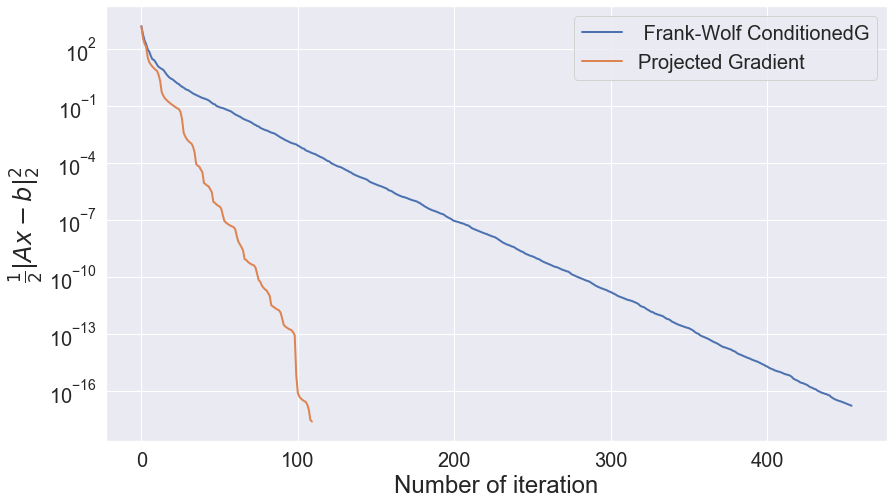

In [239]:
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

y_hist_f_cg = [f(x) for x in cg['conv_array']]
y_hist_f_pg = [f(x) for x in pg['conv_array']]

plt.figure(figsize = (14, 8))
plt.semilogy(y_hist_f_cg ,linewidth=2, label=' Frank-Wolf ConditionedG')


plt.semilogy(y_hist_f_pg , linewidth=2, label='Projected Gradient')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Number of iteration", fontsize=24)
plt.ylabel(r"$\frac{1}{2}\|Ax - b\|^2_2$", fontsize=24)
plt.legend(loc="best", fontsize=20)


In [243]:
p = ProjectedGradientDescent(f, gradf, projection, x0, max_iter=20000, tol=1e-4)
res = %timeit -o -q p

In [244]:
res

<TimeitResult : 30.4 ns ± 4.35 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)>

In [250]:
eps = [10**(-i) for i in range(8)]
time_pg = np.zeros(len(eps))
time_cg = np.zeros(len(eps))
iter_pg = np.zeros(len(eps))
iter_cg = np.zeros(len(eps))
for i, tol in tqdm(enumerate(eps)):
    res = %timeit -o -q ProjectedGradientDescent(f, gradf, projection, x0, max_iter=20000, tol=tol)
    p = ProjectedGradientDescent(f, gradf, projection, x0, max_iter=20000, tol=tol)
    time_pg[i] = res.average
    iter_pg[i] = p["num_iter"]
    res = %timeit -o -q FrankWolfMethod(f, gradf,linsolver, x0, max_iter=20000, tol=tol)
    c = FrankWolfMethod(f, gradf,linsolver, x0, max_iter=20000, tol=tol)
    time_cg[i] = res.average
    iter_cg[i] = c["num_iter"]

8it [01:33, 11.67s/it]


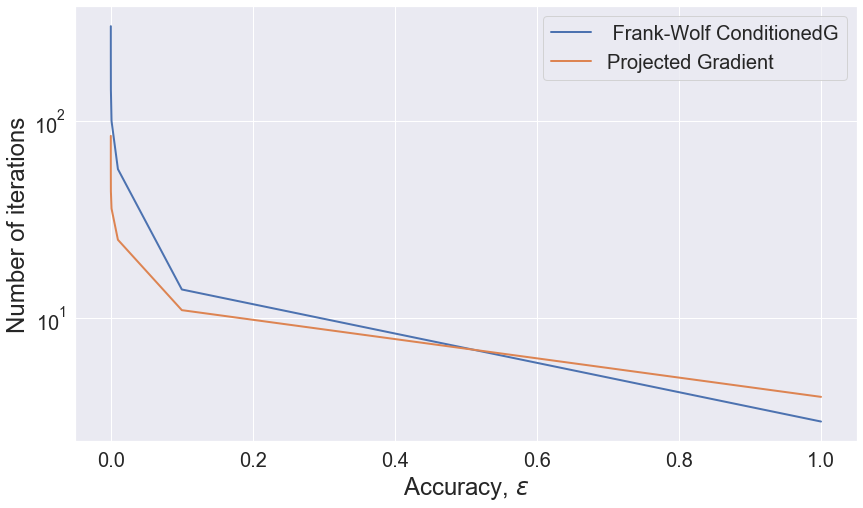

In [251]:
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize = (14, 8))
plt.semilogy(eps, iter_cg ,linewidth=2, label=' Frank-Wolf ConditionedG')



plt.semilogy(eps,iter_pg , linewidth=2, label='Projected Gradient')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=24)
plt.ylabel("Number of iterations", fontsize=24)
plt.legend(loc="best", fontsize=20)


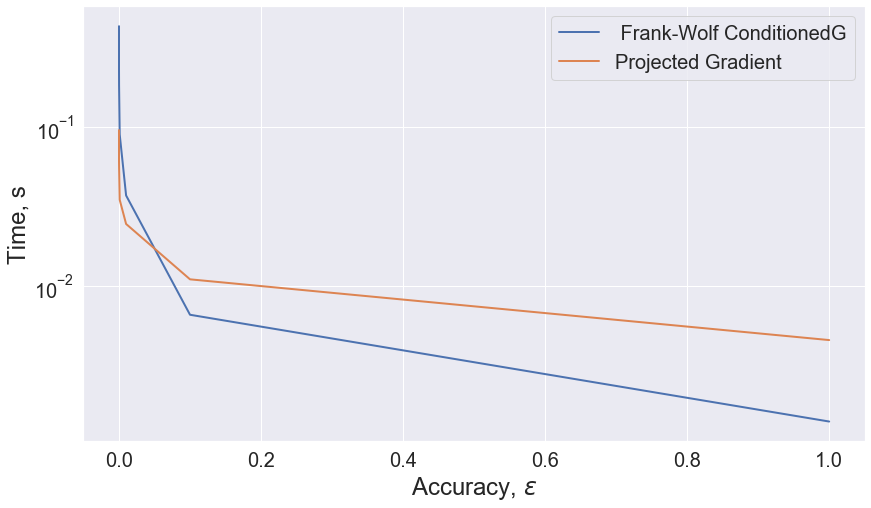

In [252]:
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize = (14, 8))
plt.semilogy(eps, time_cg ,linewidth=2, label=' Frank-Wolf ConditionedG')



plt.semilogy(eps,time_pg , linewidth=2, label='Projected Gradient')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=24)
plt.ylabel("Time, s", fontsize=24)
plt.legend(loc="best", fontsize=20)


## Пример 2
 Рассмотрим задачу: 
\begin{equation*}
\begin{split}
& \min \frac{1}{2}\|Ax - b \|^2_2 \\
\text{s.t. } & \| x\|_1 \leq 1 \\
& x_i \geq 0
\end{split}
\end{equation*}

In [256]:
import cvxpy as cvx
x = cvx.Variable(n)
obj = cvx.Minimize(0.5 * cvx.norm2(A * x - b)**2)
constr = [cvx.norm(x, 1) <= 1, x >= 0]
problem = cvx.Problem(objective=obj, constraints=constr)
value = problem.solve()
x_cvx = np.array(x.value).ravel()
print("CVX optimal value =", value)

CVX optimal value = 2732.561730371877


/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [257]:

def linsolver2(gradient):
    x = np.zeros(gradient.shape[0])
    idx_min = np.argmin(gradient)
    if gradient[idx_min] > 0:
        x[idx_min] = 0
    else:
        x[idx_min] = 1
    return x

In [258]:
def projection2(y):
    x = y.copy()
    if np.all(x >= 0) and np.sum(x) <= 1:
        return x
    x = np.clip(x, 0, np.max(x))
    if np.sum(x) <= 1:
        return x
    n = x.shape[0]
    bget = False
    x.sort()
    x = x[::-1]
    temp_sum = 0
    t_hat = 0
    for i in range(n - 1):
        temp_sum += x[i]
        t_hat = (temp_sum - 1.0) / (i + 1)
        if t_hat >= x[i + 1]:
            bget = True
            break
    if not bget:
        t_hat = (temp_sum + x[n - 1] - 1.0) / n
    return np.maximum(y - t_hat, 0)

In [255]:
x0 = np.random.rand(n)* 10
x0 = x0 / x0.sum()
cg =  FrankWolfMethod(f, gradf,linsolver2, x0, max_iter=20000, tol=1e-10)
x_cg = cg['x']
print("Optimal value CG =", f(x_cg))

Optimal value CG = 2732.561730595393


In [259]:

pg = ProjectedGradientDescent(f, gradf, projection2, x0, max_iter=20000, tol=1e-10)
x_pg = pg['x']
print("Optimal value PG =", f(x_pg))

Optimal value PG = 2732.5617305931023


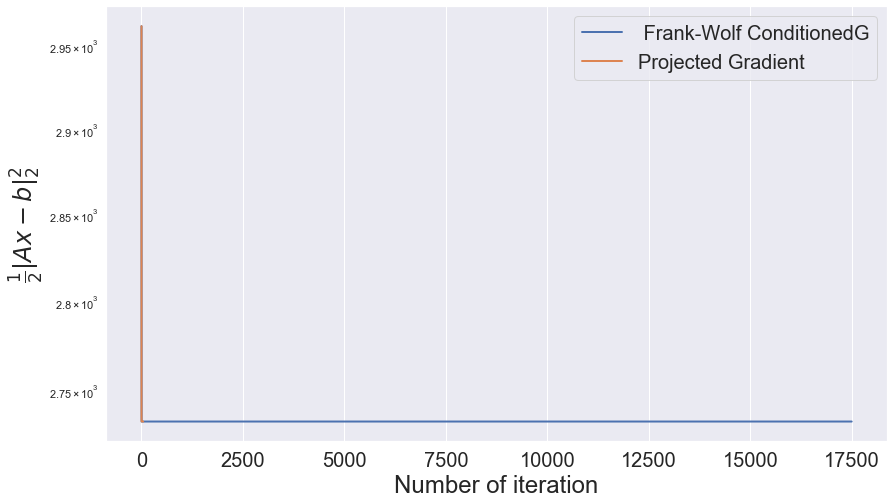

In [260]:
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

y_hist_f_cg = [f(x) for x in cg['conv_array']]
y_hist_f_pg = [f(x) for x in pg['conv_array']]

plt.figure(figsize = (14, 8))
plt.semilogy(y_hist_f_cg ,linewidth=2, label=' Frank-Wolf ConditionedG')


plt.semilogy(y_hist_f_pg , linewidth=2, label='Projected Gradient')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Number of iteration", fontsize=24)
plt.ylabel(r"$\frac{1}{2}\|Ax - b\|^2_2$", fontsize=24)
plt.legend(loc="best", fontsize=20)



In [261]:
eps = [10**(-i) for i in range(8)]
time_pg = np.zeros(len(eps))
time_cg = np.zeros(len(eps))
iter_pg = np.zeros(len(eps))
iter_cg = np.zeros(len(eps))
for i, tol in tqdm(enumerate(eps)):
    res = %timeit -o -q ProjectedGradientDescent(f, gradf, projection2, x0, max_iter=20000, tol=tol)
    p = ProjectedGradientDescent(f, gradf, projection2, x0, max_iter=20000, tol=tol)
    time_pg[i] = res.average
    iter_pg[i] = p["num_iter"]
    res = %timeit -o -q FrankWolfMethod(f, gradf,linsolver2, x0, max_iter=20000, tol=tol)
    c = FrankWolfMethod(f, gradf,linsolver2, x0, max_iter=20000, tol=tol)
    time_cg[i] = res.average
    iter_cg[i] = c["num_iter"]

8it [06:21, 47.63s/it]


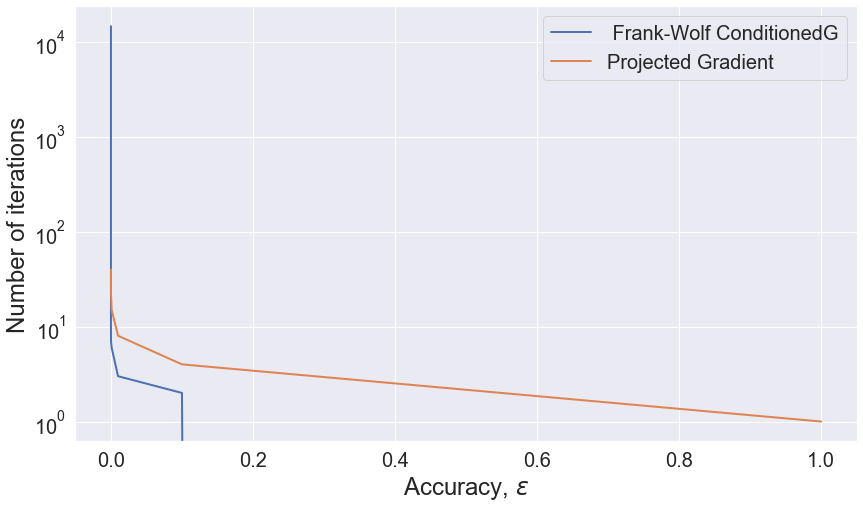

In [263]:
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize = (14, 8))
plt.semilogy(eps, iter_cg ,linewidth=2, label=' Frank-Wolf ConditionedG')



plt.semilogy(eps,iter_pg , linewidth=2, label='Projected Gradient')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=24)
plt.ylabel("Number of iterations", fontsize=24)
plt.legend(loc="best", fontsize=20)


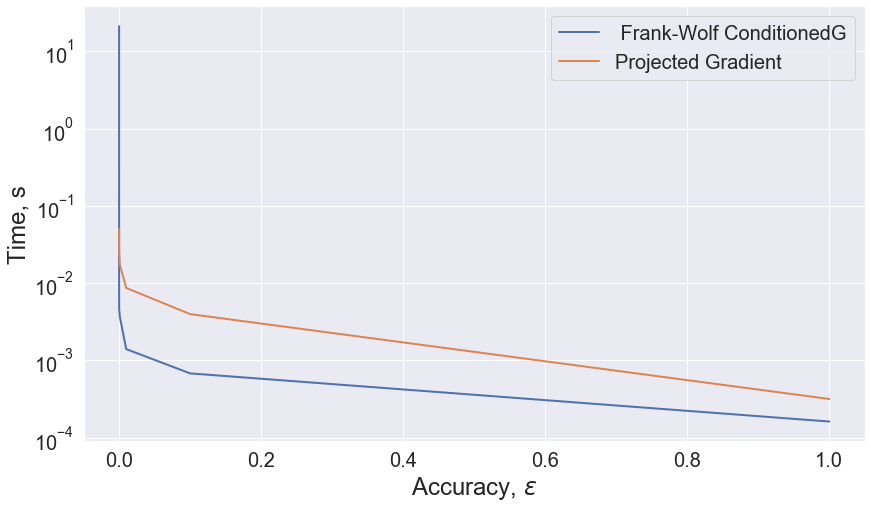

In [264]:
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize = (14, 8))
plt.semilogy(eps, time_cg ,linewidth=2, label=' Frank-Wolf ConditionedG')



plt.semilogy(eps,time_pg , linewidth=2, label='Projected Gradient')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r"Accuracy, $\varepsilon$", fontsize=24)
plt.ylabel("Time, s", fontsize=24)
plt.legend(loc="best", fontsize=20)
